# LightGBMによる競馬レース結果予測モデル

このノートブックでは、収集した競馬データを用いてLightGBMによる回帰モデルを構築し、レースの着順（rank）を予測します。

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import japanize_matplotlib

# データの読み込み
# ノートブックは 'notebook' ディレクトリにあるため、データは '../data' から読み込みます
race_results = pd.read_pickle("../data/race_results.pkl")

# データサイズの確認
print(f"Data Shape: {race_results.shape}")

# データの先頭5行を表示して中身を確認
display(race_results.head())

Data Shape: (520396, 13)


,着 順,枠 番,馬 番,馬名,性齢,斤量,騎手,タイム,着差,単勝,人 気,馬体重,調教師
race_id,,,,,,,,,,,,,
202206020703,1,7,14,サクセスミノル,牡3,56.0,ルメール,1:54.1,NaN,1.9,1.0,478(-6),[東] 中舘英二
202206020703,2,2,3,フォーワンセルフ,牡3,56.0,横山和生,1:54.2,1/2,12.5,4.0,514(+2),[東] 小桧山悟
202206020703,3,8,16,ライリッズ,牡3,56.0,岩田康誠,1:54.4,1.1/4,4.0,2.0,480(+4),[東] 宮田敬介
202206020703,4,6,11,ロルバーンスカイ,牡3,56.0,勝浦正樹,1:54.6,1,10.3,3.0,444(-4),[東] 新開幸一
202206020703,5,3,6,ブレイク,牡3,56.0,丹内祐次,1:55.0,2.1/2,66.8,11.0,464(-6),[東] 黒岩陽一


## 前処理 (Preprocessing)

生のデータフレームからモデル学習に必要な特徴量を抽出し、数値データへの変換や欠損値の処理を行います。

In [ ]:
def preprocess_race_results(df):
    """
    レース結果データのデータフレームを受け取り、前処理を行ったデータフレームを返します。
    """
    df = df.copy()
    
    # --- 着順 (Rank) の処理 --- 
    # '着 順' カラムを数値に変換します。
    # '除' (除外), '中' (中止), '取' (取消) などの数値以外のデータは NaN (欠損値) になり、その後削除します。
    df['rank'] = pd.to_numeric(df['着 順'], errors='coerce')
    df = df.dropna(subset=['rank'])
    df['rank'] = df['rank'].apply(lambda x: 1 if x <= 3 else 0) 
    
    # --- 性別と年齢 (Sex and Age) --- 
    # '性齢' カラム (例: "牡3") を性別 ("牡") と年齢 (3) に分割します。
    df['sex'] = df['性齢'].str[0]
    df['age'] = df['性齢'].str[1:].astype(int)
    
    # --- 馬体重 (Weight) --- 
    # '馬体重' カラム (例: "466(-2)") から、当日の体重 (466) と増減 (-2) を抽出します。
    # 正規表現を使ってカッコ内の数値とそれ以外を分離します。
    df['weight'] = pd.to_numeric(df['馬体重'].str.split('(').str[0], errors='coerce')
    df['weight_diff'] = pd.to_numeric(df['馬体重'].str.extract(r'\((.+)\)')[0], errors='coerce')
    
    # --- 単勝オッズと人気 (Odds and Popularity) --- 
    # 数値型に変換します。
    df['odds'] = pd.to_numeric(df['単勝'], errors='coerce')
    df['popularity'] = pd.to_numeric(df['人 気'], errors='coerce')
    
    # --- 斤量、枠番、馬番 --- 
    # これらも数値型として扱えるように変換します。
    df['weight_carry'] = pd.to_numeric(df['斤量'], errors='coerce')
    df['waku'] = pd.to_numeric(df['枠 番'], errors='coerce')
    df['umaban'] = pd.to_numeric(df['馬 番'], errors='coerce')
    
    # --- カテゴリ変数の処理 --- 
    # LightGBMはカテゴリ変数を直接扱えますが、型を 'category' に変換しておく必要があります。
    categorical_cols = ['sex', '騎手', '調教師', '馬名']
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')
    
    return df

# 前処理の実行
df_processed = preprocess_race_results(race_results)

# 前処理後のデータ確認
print(f"Processed Data Shape: {df_processed.shape}")
display(df_processed.head())

Processed Data Shape: (515909, 23)


,着 順,枠 番,馬 番,馬名,性齢,斤量,騎手,タイム,着差,単勝,...,rank,sex,age,weight,weight_diff,odds,popularity,weight_carry,waku,umaban
race_id,,,,,,,,,,,,,,,,,,,,,
202206020703,1,7,14,サクセスミノル,牡3,56.0,ルメール,1:54.1,NaN,1.9,...,1.0,牡,3,478.0,-6.0,1.9,1.0,56.0,7,14
202206020703,2,2,3,フォーワンセルフ,牡3,56.0,横山和生,1:54.2,1/2,12.5,...,2.0,牡,3,514.0,2.0,12.5,4.0,56.0,2,3
202206020703,3,8,16,ライリッズ,牡3,56.0,岩田康誠,1:54.4,1.1/4,4.0,...,3.0,牡,3,480.0,4.0,4.0,2.0,56.0,8,16
202206020703,4,6,11,ロルバーンスカイ,牡3,56.0,勝浦正樹,1:54.6,1,10.3,...,4.0,牡,3,444.0,-4.0,10.3,3.0,56.0,6,11
202206020703,5,3,6,ブレイク,牡3,56.0,丹内祐次,1:55.0,2.1/2,66.8,...,5.0,牡,3,464.0,-6.0,66.8,11.0,56.0,3,6


## 特徴量の選択とデータ分割 (Feature Selection & Splitting)

学習に使用する特徴量を選定し、データを学習用 (Train) とテスト用 (Test) に分割します。

In [4]:
# 使用する特徴量のリスト
features = [
    'waku', 'umaban',          # 枠番、馬番
    'weight_carry',            # 斤量
    'odds', 'popularity',      # 単勝オッズ、人気
    'sex', 'age',              # 性別、年齢
    'weight', 'weight_diff',   # 馬体重、体重増減
    '騎手', '調教師'           # 騎手、調教師（カテゴリ変数）
    ]

# 予測対象（目的変数）：着順
target = 'rank'

# 特徴量または目的変数に欠損値がある行を削除
# ※ 実際の運用では欠損値補完などを検討する場合もあります
df_model = df_processed[features + [target]].dropna()

# 説明変数 (X) と目的変数 (y) に分離
X = df_model[features]
y = df_model[target]

# --- 時系列スプリットへの変更 --- 
# 競馬データは時系列データであるため、未来のデータで過去を予測する「リーク」を防ぐ必要があります。
# race_id (index) は年を含むため、indexでソートすることで概ね時系列順になります。
# ランダムシャッフルを行わず (shuffle=False)、データの後半をテストデータとします。

# インデックスでソート（念のため）
X = X.sort_index()
y = y.sort_index()

# データを学習用とテスト用に分割 (テストデータは全体の20%)
# shuffle=False にすることで、時系列を維持したまま分割します
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: (412724, 11)
Test set shape: (103181, 11)


## LightGBMによる学習 (Training)

LightGBMの回帰モデルを学習させます。

In [5]:
# LightGBM用のデータセットを作成
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# ハイパーパラメータの設定
params = {
    'objective': 'regression',      # 回帰問題（着順を数値として予測）
    'metric': 'rmse',               # 評価指標：RMSE (二乗平均平方根誤差)
    'boosting_type': 'gbdt',        # 勾配ブースティング決定木
    'learning_rate': 0.05,          # 学習率
    'num_leaves': 31,               # 決定木の葉の最大数
    'verbose': -1,                  # ログ出力を抑制
    'feature_fraction': 0.9,        # 学習ごとに使用する特徴量の割合（過学習防止）
    'bagging_fraction': 0.8,        # バギング（データサンプリング）の割合
    'bagging_freq': 5               # バギングを行う頻度
}

# モデルの学習実行
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],  # 検証用データセット
    num_boost_round=1000,                # 最大イテレーション数
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # 50回改善がなければ学習を早期終了
        lgb.log_evaluation(100)                  # 100回ごとに評価指標を表示
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3.38717	valid_1's rmse: 3.40023
[200]	training's rmse: 3.34324	valid_1's rmse: 3.39888
Early stopping, best iteration is:
[174]	training's rmse: 3.35211	valid_1's rmse: 3.39786


## 評価 (Evaluation)

テストデータに対する予測精度を確認し、どの特徴量が重要だったかを可視化します。

Test RMSE: 3.3979
※ RMSEは予測値と実際の着順のズレの平均的な大きさを表します。値が小さいほど精度が高いです。


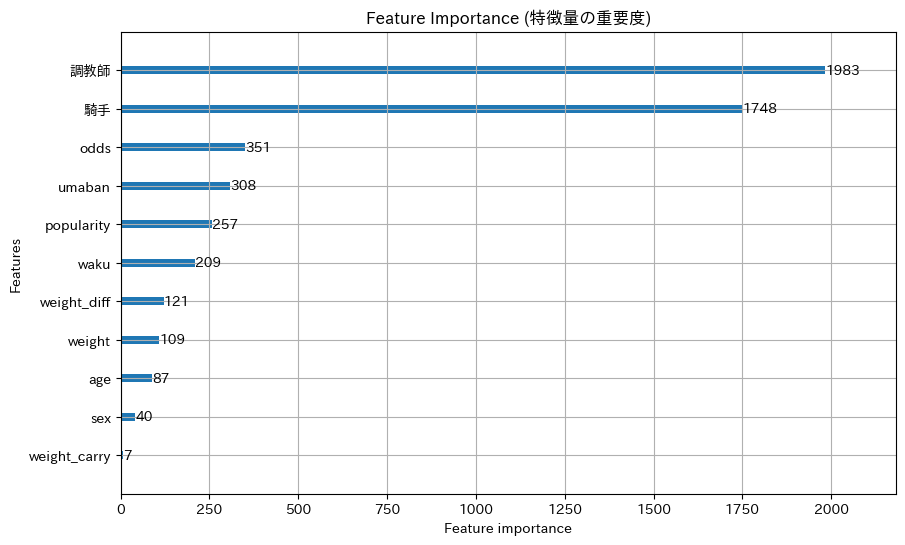

In [6]:
# テストデータで予測を実行
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# RMSE (精度) の計算
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {rmse:.4f}')
print("※ RMSEは予測値と実際の着順のズレの平均的な大きさを表します。値が小さいほど精度が高いです。")

# 特徴量重要度のプロット
lgb.plot_importance(model, figsize=(10, 6))
plt.title("Feature Importance (特徴量の重要度)")
plt.show()

In [ ]:
# 実際の収益でモデルを判定する
# モデルに対し、未知のレースを1年分投入し、想定EVとの乖離を検証する
# 頭数を多く検証したいため、3着以内に入賞するかを目的変数として設定し、複勝による回収率を計測する